# Image Captioning

Genratation of caption for images by using CNN-RNN model on [COCO](https://cocodataset.org/#home) datset


## Setup


1. Clone the [COCO API repo](https://github.com/cocodataset/cocoapi) into *this project's directory*:
```
git clone https://github.com/cocodataset/cocoapi.git
```

2. Setup COCO API (also described in the readme [here](https://github.com/cocodataset/cocoapi)):
```
cd cocoapi/PythonAPI
make
cd ..
```

In [10]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from google.colab import drive
import torchvision.datasets as dset
import torch
import math
from tqdm.notebook import tqdm

# drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Academic/Projects/Image_caption/';
path2data = "./data/train2014"
path2json = "./data/annotations/captions_train2014.json"

### Download dataset

Download the dataset in `data` directory

In [11]:
%%capture
!sudo apt install aria2
!aria2c --auto-file-renaming=false -x 10 -j 10 http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -n annotations_trainval2014.zip -d data
!rm *.zip
!aria2c --auto-file-renaming=false -x 10 -j 10 http://images.cocodataset.org/zips/train2014.zip
!unzip -n train2014.zip -d data
!rm *.zip
!aria2c --auto-file-renaming=false -x 10 -j 10 http://images.cocodataset.org/zips/val2014.zip
!unzip -n val2014.zip -d data
!rm *.zip
# Test data set
!aria2c --auto-file-renaming=false -x 10 -j 10 http://images.cocodataset.org/zips/test2014.zip
!unzip -n test2014.zip -d data
!rm *.zip
!aria2c --auto-file-renaming=false -x 10 -j 10 http://images.cocodataset.org/annotations/image_info_test2014.zip
!unzip -n image_info_test2014.zip -d data
!rm *.zip

## Vocublary creation

In [61]:
import nltk
nltk.download('punkt') #uncomment this if ge error Resource punkt not found. Please use the NLTK Downloader to obtain the resource:
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary:
  def __init__(self, annFile, vocab_threshold, vocab_file='vocab.pkl', start_word="<start>", end_word="<end>", unk_word="<unk>"):
    self.vocab_threshold = vocab_threshold
    self.vocab_file = vocab_file
    self.start_word = start_word
    self.end_word = end_word
    self.unk_word = unk_word
    self.annFile = annFile

    if os.path.exists(self.vocab_file):
      print("loading already saved file")
      with open(self.vocab_file, 'rb') as f:
        vocab = pickle.load(f)
        self.word2idx = vocab.word2idx
        self.idx2word = vocab.idx2word
    else:
      self.init_vocab()
      self.build_vocab()


  def init_vocab(self):
    self.word2idx = {}
    self.idx2word = {}

    # Add the special tokens to the vocabulary.
    self.word2idx[self.start_word] = 0
    self.word2idx[self.end_word] = 1
    self.word2idx[self.unk_word] = 2

    self.idx2word[0] = self.start_word
    self.idx2word[1] = self.end_word
    self.idx2word[2] = self.unk_word


  def build_vocab(self):
    # Build the vocabulary.
    coco = COCO(self.annFile)
    ids = coco.anns.keys()
    counter = Counter()
    for i, id in enumerate(ids):
      caption = str(coco.anns[id]['caption'])
      tokens = nltk.tokenize.word_tokenize(caption.lower())
      counter.update(tokens)

      if i % 100000 == 0:
        print("[{}/{}] Tokenized the captions.".format(i, len(ids)))

    # If the word frequency is less than 'vocab_threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

    # Create a mapping from the words to the indices.
    idx = 3
    for word in words:
      self.word2idx[word] = idx
      self.idx2word[idx] = word
      idx += 1

    # Save the vocabulary to a file.
    with open(self.vocab_file, 'wb') as f:
      pickle.dump(self, f)

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx[self.unk_word]
    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

  def get_words(self, encoding):
    words = []
    for i, e in enumerate(encoding):
      word = self.idx2word[e]
      if word == self.end_word or i >= 19:
        break
      words.append(word)
    words.append(self.end_word)
    return words

  def get_sentence(self, encoding):
    words = self.get_words(encoding)
    words = words[1:]
    words = words[:-1]
    return " ".join(words)


vocab = Vocabulary(annFile=path2json, vocab_threshold=5, vocab_file=drive_path+'vocab.pkl')

loading already saved file


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# testing vocabulary
sample_caption = 'horse and buggy going down a road next to a car'
sample_token = nltk.tokenize.word_tokenize(str(sample_caption).lower())
start_word, end_word = '<start>', '<end>'
sample_token.insert(0, start_word)
sample_token.append(end_word)
transformed_caption = [vocab(word) for word in sample_token]
print(sample_token)
print(transformed_caption)

['<start>', 'horse', 'and', 'buggy', 'going', 'down', 'a', 'road', 'next', 'to', 'a', 'car', '<end>']
[0, 134, 6, 2182, 981, 54, 3, 40, 364, 161, 3, 36, 1]


In [14]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing = SmoothingFunction()

def calculate_blue_score(prediction, references):
  return sentence_bleu([reference.split() for reference in references],
                       prediction.split(),
                       weights=[0.7, 0.2, 0.09, 0.01],
                       smoothing_function=smoothing.method1)



In [15]:
# testing blue score
prediction = 'horse and buggy going down a road next to a car'
references = ['A horse driven carriage on a city street.',
             'A horse drawn carriage coming down a city street',
             'Man riding on carriage lead by a horse.',
             'A horse and carriage walks down the street as a car follows beside it.']

calculate_blue_score(prediction, references)

0.28894530934562657

## Dataset Creation

In [16]:
import torch
from torchvision import transforms


image_transform = transforms.Compose([
  transforms.Resize(256),                          # smaller edge of image resized to 256
  transforms.RandomCrop(224),                      # get 224x224 crop from random location
  transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
  transforms.ToTensor(),                           # convert the PIL Image to a tensor
  transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                        (0.229, 0.224, 0.225))])

def vocab_transform(captions, start_word = '<start>', end_word='<end>', vocab_size = 20):
  word = captions[0]
  token = [start_word]
  token.extend(nltk.tokenize.word_tokenize(str(word).lower()))
  token.extend([end_word for i in range(20)])
  token = token[:vocab_size-1]
  token.append(end_word)
  result = [vocab(word) for word in token]
  return torch.Tensor(result).long()

In [17]:
%%capture
# untransformed raw dataset
coco_train_raw = dset.CocoCaptions(root=path2data, annFile = path2json)

# transformed dataset
coco_train = dset.CocoCaptions(root=path2data, annFile = path2json,
                               transform=image_transform,
                               target_transform=vocab_transform)

Caption:  Two youth soccer teams are playing each other. 
Transformed Caption:  tensor([   0,   50, 1828,  915, 3608,   52,  355,   72,  409,   18,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1]) torch.Size([20]) torch.LongTensor


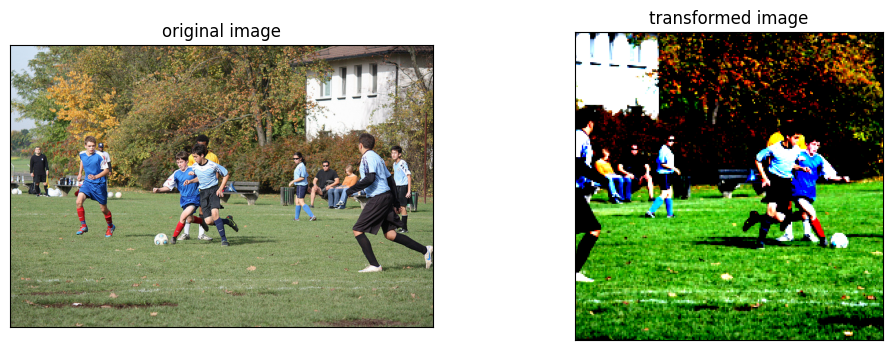

In [18]:
ind = np.random.choice(np.arange(0, len(coco_train)));
img, target = coco_train_raw[ind]
transformed_image, transformed_caption = coco_train[ind]

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(img))
ax1.set_title('original image')

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(np.transpose(transformed_image.numpy(), (1, 2, 0)))
ax2.set_title('transformed image')

print("Caption: ",  target[0])
print("Transformed Caption: ", transformed_caption, transformed_caption.shape, transformed_caption.type())

## Model

### Encoder

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from torchvision import transforms

class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.embed = nn.Linear(resnet.fc.in_features, embed_size)
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

  def forward(self, images):
    with torch.no_grad():
      features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.embed(features)
    features = self.bn(features)
    return features

In [72]:
from torch.utils.data import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

embed_size = 256
encoder = EncoderCNN(256)


train_dataloader = DataLoader(coco_train, batch_size=10, shuffle=True)
img, captions = next(iter(train_dataloader))

encoder.to(device)
img = img.to(device)

features = encoder(img)

print('type(features):', type(features))
print('features.shape:', features.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


### Decoder

In [73]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        """Decode image feature vectors and generates captions."""
        captions = captions[:,:-1]
        embeddings = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """Accept a pre-processed image tensor (inputs) and return predicted
        sentence (list of tensor ids of length max_len). This is the greedy
        search approach.
        """
        sampled_ids = []
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            # Get the index (in the vocabulary) of the most likely integer that
            # represents a word
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        return sampled_ids

    def sample_beam_search(self, inputs, states=None, max_len=20, beam_width=5):
        """Accept a pre-processed image tensor and return the top predicted
        sentences. This is the beam search approach.
        """
        # Top word idx sequences and their corresponding inputs and states
        idx_sequences = [[[], 0.0, inputs, states]]
        for _ in range(max_len):
            # Store all the potential candidates at each step
            all_candidates = []
            # Predict the next word idx for each of the top sequences
            for idx_seq in idx_sequences:
                hiddens, states = self.lstm(idx_seq[2], idx_seq[3])
                outputs = self.linear(hiddens.squeeze(1))
                # Transform outputs to log probabilities to avoid floating-point
                # underflow caused by multiplying very small probabilities
                log_probs = F.log_softmax(outputs, -1)
                top_log_probs, top_idx = log_probs.topk(beam_width, 1)
                top_idx = top_idx.squeeze(0)
                # create a new set of top sentences for next round
                for i in range(beam_width):
                    next_idx_seq, log_prob = idx_seq[0][:], idx_seq[1]
                    next_idx_seq.append(top_idx[i].item())
                    log_prob += top_log_probs[0][i].item()
                    # Indexing 1-dimensional top_idx gives 0-dimensional tensors.
                    # We have to expand dimensions before embedding them
                    inputs = self.embed(top_idx[i].unsqueeze(0)).unsqueeze(0)
                    all_candidates.append([next_idx_seq, log_prob, inputs, states])
            # Keep only the top sequences according to their total log probability
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            idx_sequences = ordered[:beam_width]
        return [idx_seq[0] for idx_seq in idx_sequences]

In [74]:
hidden_size = 512

# Store the size of the vocabulary.
vocab_size = len(vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.to(device)
captions = captions.to(device)

# Pass the encoder output and captions through the decoder
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 20, 8852])


## Training

In [137]:
%%capture
model_path = drive_path + 'model/'

batch_size = 512 if torch.cuda.is_available() else 32
vocab_threshold = 5     # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file
embed_size = 256        # dimensionality of image and word embeddings
hidden_size = 512       # number of features in hidden state of the RNN decoder
num_epochs = 10          # number of training epochs

checkpoint_file = drive_path+'checkpoint/last.pth'
best_model_path = drive_path+'model/best.pth'
stat_path = drive_path+'model/stats.pth'


coco_train = dset.CocoCaptions(root=path2data, annFile = path2json,
                               transform=image_transform,
                               target_transform=vocab_transform)

path2valdata = './data/val2014'
path2valjson = './data/annotations/captions_val2014.json'
coco_val = dset.CocoCaptions(root=path2valdata, annFile=path2valjson,
                             transform=image_transform,
                             target_transform=vocab_transform)

train_dataloader = DataLoader(coco_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(coco_val, batch_size=batch_size, shuffle=True)

In [24]:
train_data_size = len(coco_train)
val_data_size = len(coco_val)

num_train_batch = train_data_size//batch_size
num_val_batch = val_data_size//batch_size

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer
optimizer = torch.optim.Adam(params=params, lr=0.001)

In [ ]:
train_losses = []
val_losses = []
val_blues = []
best_val_blue = 0
start_epoch = 1

# load the last checkpoint saved
if os.path.exists(checkpoint_file):
  checkpoint = torch.load(checkpoint_file)
  encoder.load_state_dict(checkpoint['encoder'])
  decoder.load_state_dict(checkpoint['decoder'])
  encoder.to(device)
  decoder.to(device)
  start_epoch = checkpoint['epoch']+1
  print(f"Loading the already saved checkpoint with {start_epoch-1} epoch completed")
  train_losses = checkpoint['train_losses']
  val_losses = checkpoint['val_losses']
  best_val_blue = checkpoint['best_val_blue']


for epoch in tqdm(range(start_epoch, num_epochs+1), total=num_epochs, initial=start_epoch-1, position=0, desc="epoch"):
  # Train once on complete dataset
  train_loss = 0

  encoder.train()
  decoder.train()

  for curr_batch in tqdm(range(1, num_train_batch+1), position=1, desc="training", leave=False, colour='green'):

    images, captions = next(iter(train_dataloader))

    # transfering to cuda if available
    images = images.to(device)
    captions = captions.to(device)

    features = encoder(images)
    outputs = decoder(features, captions)

    loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()


  train_loss /= train_data_size
  train_losses.append(train_loss)

  # Validate the model on val dataset
  val_loss = 0

  total_blue_score = 0
  encoder.eval()
  decoder.eval()
  smoothing = SmoothingFunction()

  with torch.no_grad():
    for curr_val_batch in tqdm(range(1, num_val_batch+1), position=1, desc="Validating", leave=False, colour='red'):
      images, caption = next(iter(val_dataloader))

      images = images.to(device)
      captions = captions.to(device)

      features = encoder(images)
      outputs = decoder(features, captions)
      loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
      val_loss += loss.item()

      # Calculate the blue score
      batch_blue = 0
      for i in range(len(outputs)):
        predicted_ids = []
        for scores in outputs[i]:
          predicted_ids.append(scores.argmax().item())

        predicted_word = vocab.get_words(predicted_ids)
        caption_word = vocab.get_words(captions[i].to('cpu').numpy())
        batch_blue += sentence_bleu([predicted_word],
                                    caption_word,
                                    smoothing_function=smoothing.method1)
      total_blue_score += batch_blue/batch_size;



    val_loss /= val_data_size
    val_losses.append(val_loss)

    total_blue_score /= num_val_batch
    val_blues.append(total_blue_score)

    if total_blue_score > best_val_blue + 0.001:
      # tqdm.write(f"Best model updated with score { total_blue_score} \n")
      best_val_blue = total_blue_score
      torch.save({"encoder": encoder.state_dict(),
                  "decoder": decoder.state_dict()},
                drive_path+'model/best.pth')

    torch.save({"encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_blues": val_blues,
                "best_val_blue": best_val_blue,
                "epoch": epoch},
               drive_path+'checkpoint/last.pth')

    torch.save({"train_losses": train_losses,
                "val_losses": val_losses,
                "val_blues": val_blues},
               drive_path+'model/stats.pth')



plt.plot(np.arange(1, num_epochs+1), train_losses, label='train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.legend()
plt.show()

Loading the already saved checkpoint with 1 epoch completed


epoch:  10%|#         | 1/10 [00:00<?, ?it/s]

	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Best model updated with score { total_blue_score} 



	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Best model updated with score { total_blue_score} 



	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Best model updated with score { total_blue_score} 



	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Best model updated with score { total_blue_score} 



	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

	 training:   0%|          | 0/161 [00:00<?, ?it/s]

	 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

## Inference

In [138]:
%%capture
# create th etest data loader
path2testjson = './data/annotations/image_info_test2014.json'
path2testdata = './data/test2014'

coco_test = dset.CocoCaptions(root=path2testdata, annFile=path2testjson)

In [75]:
if os.path.exists(best_model_path):
  model = torch.load(best_model_path, map_location=device)
  encoder.load_state_dict(model['encoder'])
  decoder.load_state_dict(model['decoder'])
  encoder.to(device)
  decoder.to(device)
  encoder.eval()
  decoder.eval()

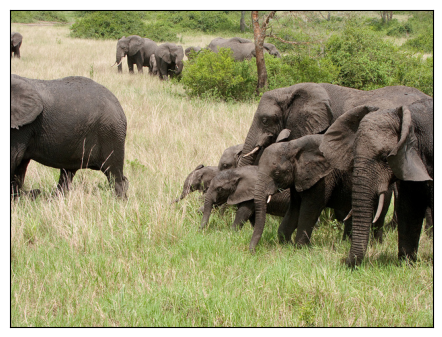

a herd of elephants standing on top of a dirt field .
a herd of elephants standing on top of a dirt field .
a herd of elephants standing next to each other .
a herd of elephants standing on top of a field .
a herd of elephants standing on top of a grass covered field .
a herd of elephants walking across a grass covered field .


In [136]:
ind = np.random.choice(np.arange(0, len(coco_test)));
img, _ = coco_test[ind]
transformed_image = image_transform(img)

features = encoder(transformed_image.unsqueeze(0)).unsqueeze(1)
output = decoder.sample(features)
caption = vocab.get_sentence(output)

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(img))
plt.show()

beam_captions = decoder.sample_beam_search(features)
print(caption)
for caption in beam_captions:
  print(vocab.get_sentence(caption))


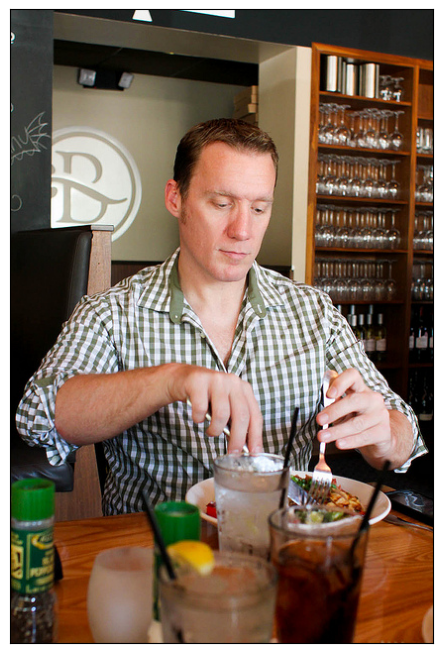

a man sitting at a table with a plate of food .



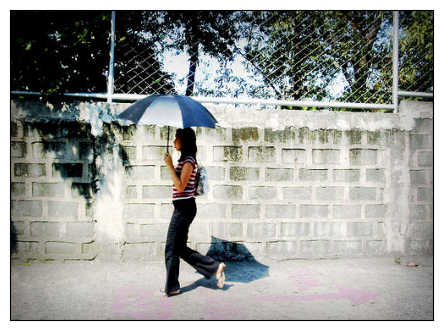

a woman walking down a street holding a black umbrella .



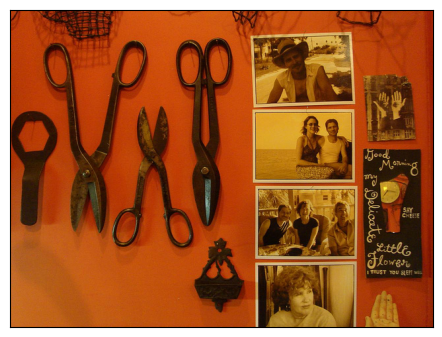

a bunch of different tools on display in a store .



In [130]:
for i in range(3):
  ind = np.random.choice(np.arange(0, len(coco_test)));
  img, _ = coco_test[ind]
  transformed_image = image_transform(img)

  features = encoder(transformed_image.unsqueeze(0)).unsqueeze(1)
  output = decoder.sample(features)
  caption = vocab.get_sentence(output)
  fig = plt.figure(figsize=(12, 16))
  ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
  ax1.imshow(np.squeeze(img))
  plt.show()
  print(caption)
  print()